In [1]:
library(ggplot2)
library(xts)
library(dplyr)
library(tidyr)
library(forecast)

Loading required package: zoo

Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric


Attaching package: 'dplyr'

The following objects are masked from 'package:xts':

    first, last

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



In [2]:
data_runoff <- list.files(path='../../data/ObservedDischarge_LBRM_2011-2014', full.names=TRUE) %>% 
    lapply(function(f) {
        data <- read.fwf(f, c(8, 11), skip=2, col.names=c('date', 'runoff'))
        data$date <- as.POSIXct(strptime(gsub(' ', '0', data$date), '%d%m%Y'))
        data$lake <- rep(substr(f, 19,21), nrow(data))
        data$subbasin <- rep(strtoi(substr(f, 22,23)), nrow(data))
        data
    }) %>%
    Reduce(function(...) merge(..., all=TRUE), .)

In [3]:
data_forcing <- list.files(path='../../data/RDRS_daily_LBRM', full.names=TRUE) %>% 
    lapply(function(f) {
        data <- read.csv(f, sep=',', skip=3, col.names=c('date', 'tmin', 'tmax', 'prec'))
        data$date <- as.POSIXct(strptime(data$date, '%Y-%m-%d'))
        data$lake <- rep(substr(f, 26,28), nrow(data))
        data$subbasin <- rep(strtoi(substr(f, 29,30)), nrow(data))
        data
    }) %>%
    Reduce(function(...) merge(..., all=TRUE), .)

In [4]:
data <- full_join(data_forcing, data_runoff, by=c('date', 'lake', 'subbasin'))

In [5]:
data %>% filter(runoff == -999900000) %>% count()
data %>% filter(date >= '2011-01-01' & date < '2015-01-01') %>% filter(is.na(runoff)) %>% group_by(lake, subbasin) %>% count()
data <- data %>% mutate(runoff=replace(runoff, runoff==-999900000, NA))

n
519


lake,subbasin,n
eri,3,1461
eri,14,1461
eri,18,1461
stc,2,1461
stc,4,1461


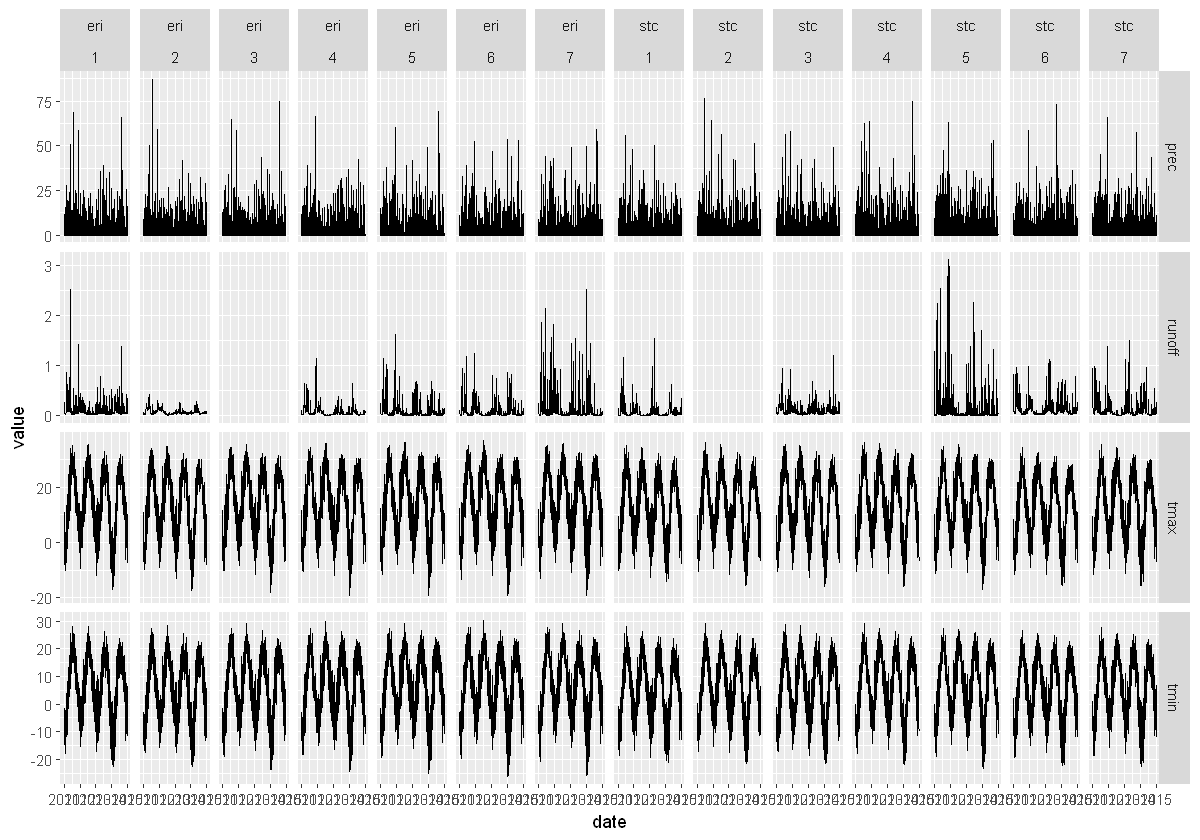

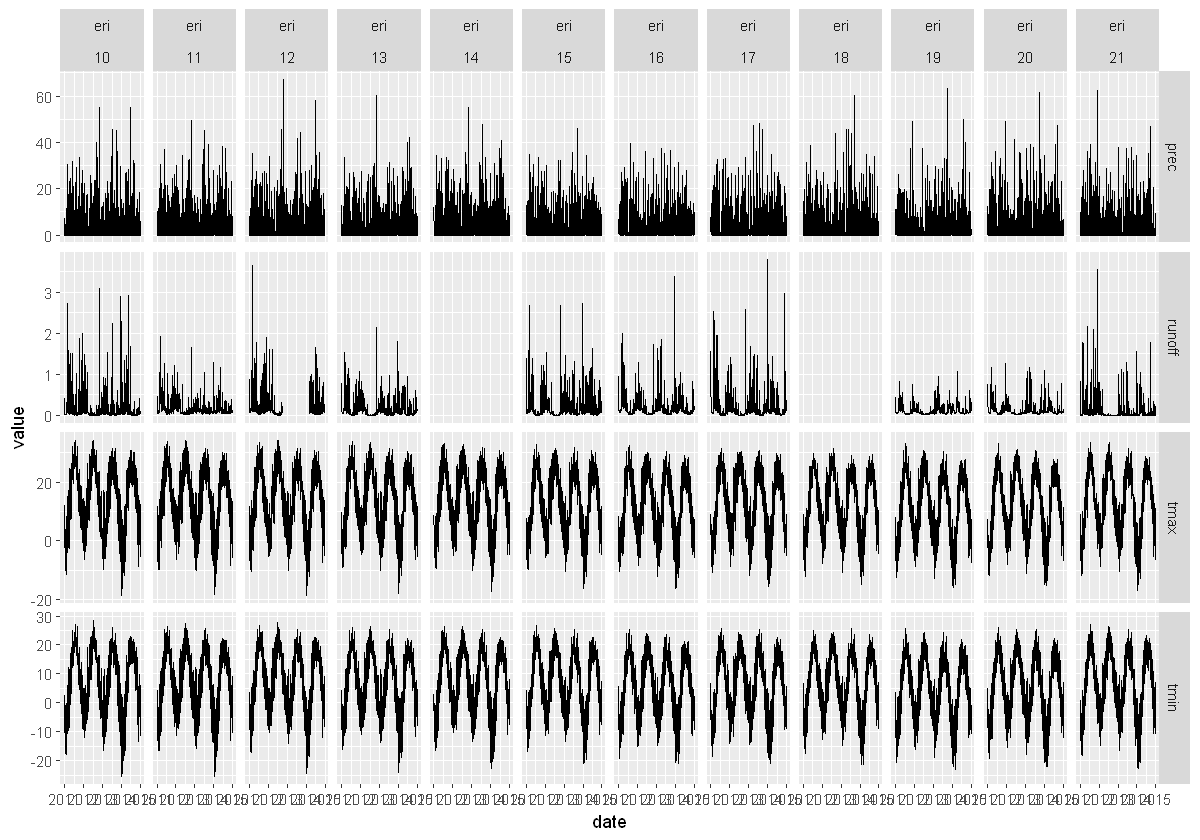

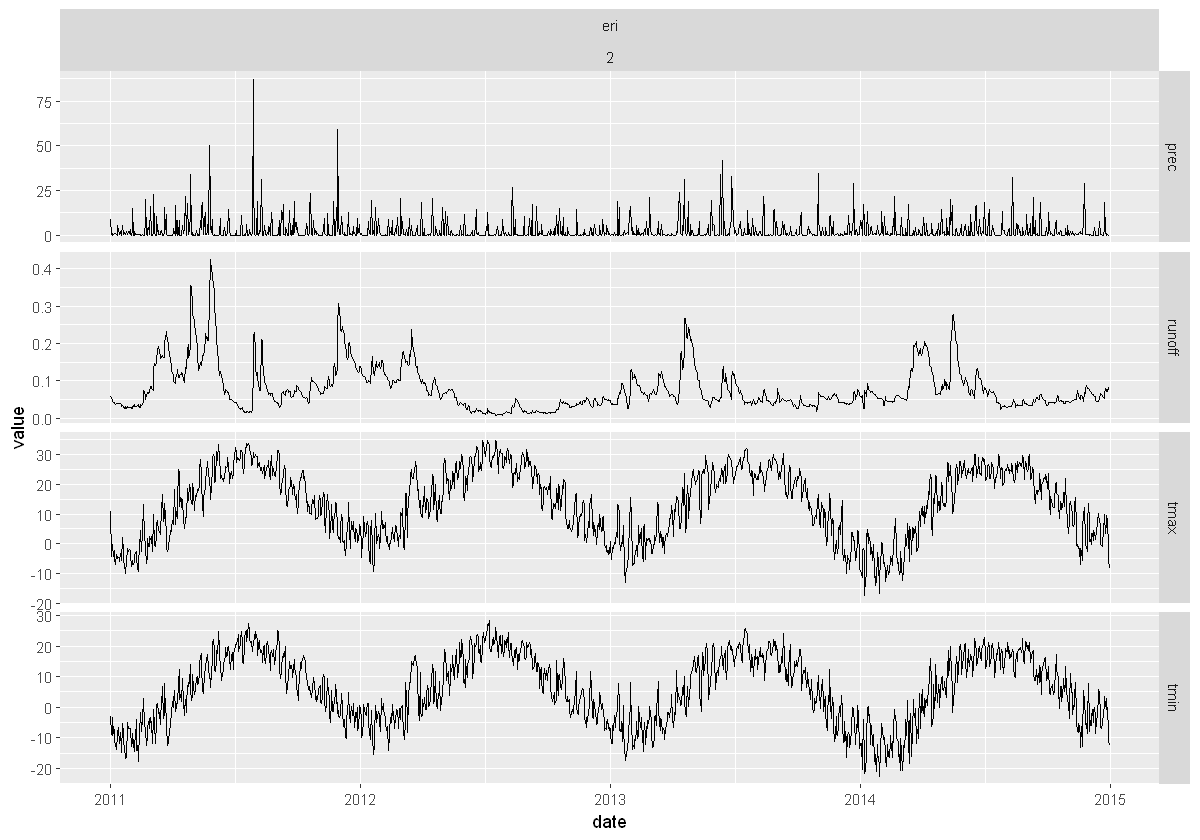

In [6]:
saved <- options(repr.plot.width=10)
# All subbasins
data %>% filter(date >= '2011-01-01' & date <= '2014-12-31') %>% filter(subbasin < 8) %>%
    gather(variable, value, -date, -lake, -subbasin) %>% 
    ggplot(aes(x=date, y=value)) + geom_line() + facet_grid(variable~lake+subbasin, scales="free_y")
data %>% filter(date >= '2011-01-01' & date <= '2014-12-31') %>% filter(subbasin >= 8) %>%
    gather(variable, value, -date, -lake, -subbasin) %>% 
    ggplot(aes(x=date, y=value)) + geom_line() + facet_grid(variable~lake+subbasin, scales="free_y")

# one subbasin in detail
data %>% filter(date >= '2011-01-01' & date <= '2014-12-31' & lake == 'eri' & subbasin == 2) %>%
    gather(variable, value, -date, -lake, -subbasin) %>% 
    ggplot(aes(x=date, y=value)) + geom_line() + facet_grid(variable~lake+subbasin, scales="free_y")
options(saved)

In [ ]:
data %>% group_by(lake, subbasin) %>% summarize_at(c('tmin', 'tmax', 'prec', 'runoff'), mean, na.rm=TRUE) %>%
    gather(variable, value, tmin:runoff) %>% 
    ggplot(aes(value)) + geom_histogram(binwidth=1) + facet_grid(variable~.)

In [6]:
data %>% group_by(lake, subbasin) %>% summarize_at(c('tmin', 'tmax', 'prec', 'runoff'), mean, na.rm=TRUE) %>%
    gather(variable, value, tmin:runoff)

lake,subbasin,variable,value
eri,01,tmin,6.482786
eri,02,tmin,5.980010
eri,03,tmin,6.643812
eri,04,tmin,6.338565
eri,05,tmin,6.899146
eri,06,tmin,7.159283
eri,07,tmin,7.388395
eri,08,tmin,7.324725
eri,09,tmin,7.340608
eri,10,tmin,7.446312


In [84]:
tseri01 <- zoo(eri01[,-1], order.by=eri01$date)
eri2012 <- window(tseri01$runoff, start='2012-01-01', end='2013-01-01')
eri2013 <- window(tseri01$runoff, start='2013-01-01', end='2014-01-01')

fit <- auto.arima(fortify(eri2012)[,2])
fit

Series: fortify(eri2012)[, 2] 
ARIMA(1,1,2) 

Coefficients:
         ar1      ma1      ma2
      0.2739  -0.4064  -0.5215
s.e.  0.0754   0.0657   0.0573

sigma^2 estimated as 0.001461:  log likelihood=676.11
AIC=-1344.22   AICc=-1344.11   BIC=-1328.61

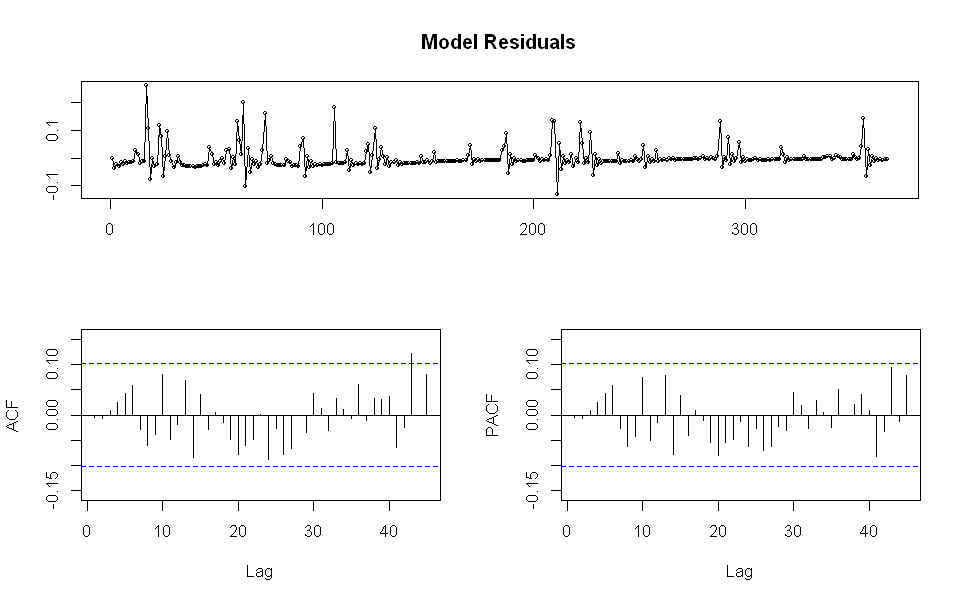

In [118]:
tsdisplay(residuals(fit), lag.max=45, main='Model Residuals')

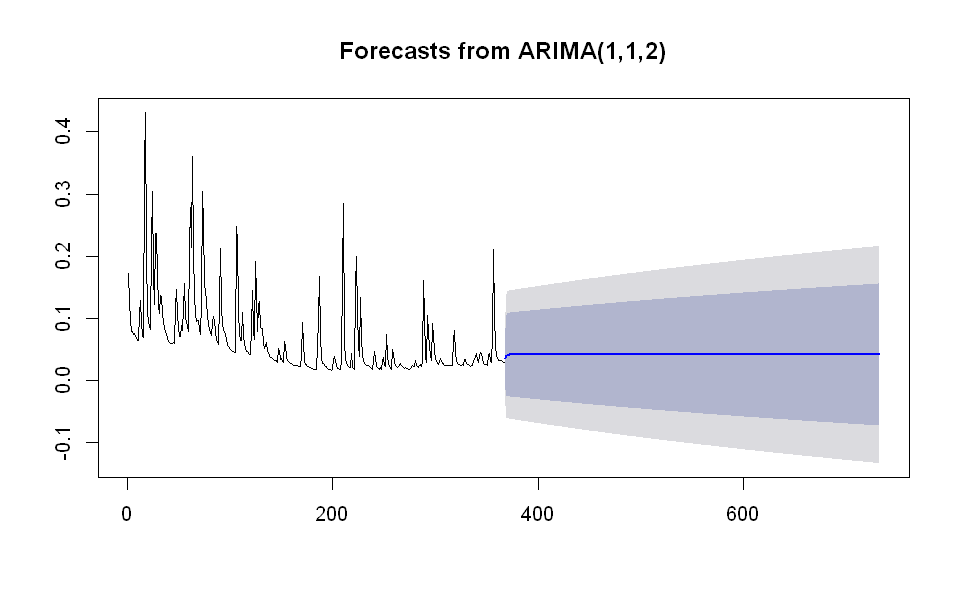

In [119]:
fcast <- forecast(fit, h=365)

plot(fcast)
